In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
import glob as glob
import warnings
import cv2
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)
from albumentations.pytorch import ToTensorV2


warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [2]:
import numpy as np
import random

In [3]:
paths = glob.glob("/kaggle/input/gaf-mapped-images-of-time-series-voltagecurrent/GAF Images/*/*")
random.shuffle(paths)

In [4]:
train_paths = paths[0:int(.8*len(paths))]
val_paths = paths[int(.8*len(paths))-1:-1]

In [5]:
train_paths[0].split('/')

['',
 'kaggle',
 'input',
 'gaf-mapped-images-of-time-series-voltagecurrent',
 'GAF Images',
 'No_fault',
 'sample_15']

In [6]:
train_df = pd.DataFrame([[folders+'/Va.png',folders+'/Vb.png',folders+'/Vc.png',folders+'/Ia.png',folders+'/Ib.png',folders+'/Ic.png',folders.split('/')[5]] for folders in train_paths],columns=['Va','Vb','Vc','Ia','Ib','Ic','Fault_type'])
val_df = pd.DataFrame([[folders+'/Va.png',folders+'/Vb.png',folders+'/Vc.png',folders+'/Ia.png',folders+'/Ib.png',folders+'/Ic.png',folders.split('/')[5]] for folders in val_paths],columns=['Va','Vb','Vc','Ia','Ib','Ic','Fault_type'])

In [7]:
train_df.head()

,Va,Vb,Vc,Ia,Ib,Ic,Fault_type
0,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,No_fault
1,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,LL
2,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,No_fault
3,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,LL
4,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,No_fault


In [8]:
a = train_df['Fault_type'].value_counts()*100
l = ['No_fault (0)','LG (1)','LLG (2)','LL (3)','LLL (4)','LLLG (5)']

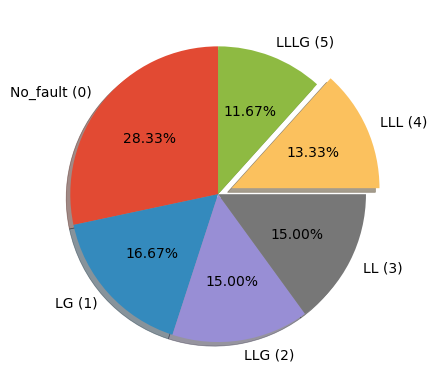

In [9]:
explode = [0,0,0,0,.1,0]
plt.style.use('ggplot')
plt.pie(a,labels = l,explode=explode,autopct='%.2f%%',startangle=90,shadow=True)
plt.show()

In [10]:
train_df['Fault_type'].value_counts()

No_fault    17
LL          10
LLG          9
LLL          9
LG           8
LLLG         7
Name: Fault_type, dtype: int64

In [11]:
val_df.head()

,Va,Vb,Vc,Ia,Ib,Ic,Fault_type
0,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,LLL
1,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,LLLG
2,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,No_fault
3,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,LG
4,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,/kaggle/input/gaf-mapped-images-of-time-series...,No_fault


In [12]:
val_df['Fault_type'].value_counts()

No_fault    6
LG          3
LLL         2
LLLG        2
LLG         2
LL          1
Name: Fault_type, dtype: int64

In [13]:
im = cv2.imread(train_df['Va'][50])

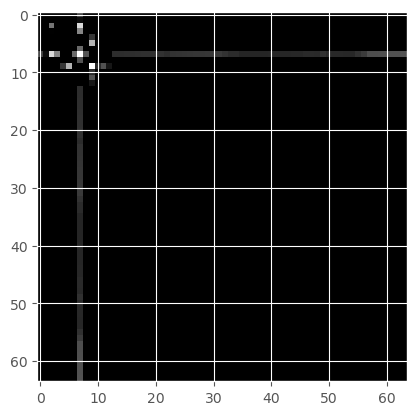

In [14]:
plt.imshow(im)
plt.show()

# Dataset

In [15]:
fault_mapping = {
    'No_fault': 0,     #no fault
    'LG': 1,     # LG fault (line A and G) 
    'LLG': 2,     # LLG fault ( line A,B and G)
    'LL': 3,     # LL fault (line B and C)
    'LLL': 4,     # LLL fault
    'LLLG': 5     # LLLG fault
}

In [16]:
class FaultDataset(Dataset):
    def __init__(self,df,transform=None):
        super().__init__()
        self.df=df
        self.transform=transform
        
        self.Va=self.df['Va']
        self.Vb=self.df['Vb']
        self.Vc=self.df['Vc']
        self.Ia=self.df['Ia']
        self.Ib=self.df['Ib']
        self.Ic=self.df['Ic']
        
        self.labels=self.df['Fault_type']
        
    def __getitem__(self,idx):
        
#         print('hi')
        path_Va = self.Va[idx]
        path_Vb = self.Vb[idx]
        path_Vc = self.Vc[idx]
        path_Ia = self.Ia[idx]
        path_Ib = self.Ib[idx]
        path_Ic = self.Ic[idx]
        
#         print('hi')
#         print(path_Va)
        
        label= torch.tensor([fault_mapping[self.labels[idx]]]).float()

        img_Va = torch.tensor(cv2.imread(path_Va))
        img_Vb = torch.tensor(cv2.imread(path_Vb))
        img_Vc = torch.tensor(cv2.imread(path_Vc))
        img_Ia = torch.tensor(cv2.imread(path_Ia))
        img_Ib = torch.tensor(cv2.imread(path_Ib))
        img_Ic = torch.tensor(cv2.imread(path_Ic))
#         print('hi')
        
        if self.transform:
            img = self.transform(image=img)['image']
        
        return [torch.permute(img_Va,(2,1,0)).float(),torch.permute(img_Vb,(2,1,0)).float(),
                torch.permute(img_Vc,(2,1,0)).float(),torch.permute(img_Ia,(2,1,0)).float(),
                torch.permute(img_Ib,(2,1,0)).float(),torch.permute(img_Ic,(2,1,0)).float(),label.float()]
    
    def __len__(self):
        return len(self.df)

In [17]:
train_dataset=FaultDataset(train_df,transform=None)
val_dataset=FaultDataset(val_df,transform=None)

In [18]:
train_dataset.__getitem__(0)[3].shape

torch.Size([3, 64, 64])

In [19]:
class vgg16(nn.Module):
    def __init__(self):
        super(vgg16,self).__init__()
        
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        
        self.conv1_1 = nn.Conv2d(3,32, kernel_size=(3,3), stride=1, padding=1)
        self.conv1_2 = nn.Conv2d(32,32, kernel_size=(3,3), stride=1, padding=1)
 
        self.conv2_1 = nn.Conv2d(32,64, kernel_size=(3,3), stride=1, padding=1)
        self.conv2_2 = nn.Conv2d(64,64, kernel_size=(3,3), stride=1, padding=1)
        
        self.conv3_1 = nn.Conv2d(64,64, kernel_size=(3,3), stride=1, padding=1)
        self.conv3_2 = nn.Conv2d(64,64, kernel_size=(3,3), stride=1, padding=1)
        self.conv3_3 = nn.Conv2d(64,128, kernel_size=(3,3), stride=1, padding=1)

        self.conv4_1 = nn.Conv2d(128,128, kernel_size=(3,3), stride=1, padding=1)
        self.conv4_2 = nn.Conv2d(128,128, kernel_size=(3,3), stride=1, padding=1)
#         self.conv4_3 = nn.Conv2d(512,512, kernel_size=(3,3), stride=1, padding=1)

#         self.conv5_1 = nn.Conv2d(512,512, kernel_size=(3,3), stride=1, padding=1)
#         self.conv5_2 = nn.Conv2d(512,512, kernel_size=(3,3), stride=1, padding=1)
#         self.conv5_3 = nn.Conv2d(512,512, kernel_size=(3,3), stride=1, padding=1)


        self.ConvLayers = nn.Sequential(
            self.conv1_1, nn.ReLU(inplace=True), self.conv1_2,nn.ReLU(inplace=True),
            self.pool,
            self.conv2_1, nn.ReLU(inplace=True), self.conv2_2,nn.ReLU(inplace=True),
            self.pool,
            self.conv3_1, nn.ReLU(inplace=True),self.conv3_2,nn.ReLU(inplace=True),self.conv3_3,nn.ReLU(inplace=True),
            self.conv4_1, nn.ReLU(inplace=True),self.conv4_2,nn.ReLU(inplace=True),
            self.pool
            
        )
        
        self.last = nn.Sequential(            
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(start_dim=1, end_dim=- 1),
            nn.Linear(768, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(32, 6),
#             nn.Sigmoid()
        )
        
    def forward(self,im1,im2,im3,im4,im5,im6):
        
        x1 = self.ConvLayers(im1)
        x2 = self.ConvLayers(im2)
        x3 = self.ConvLayers(im3)
        x4 = self.ConvLayers(im4)
        x5 = self.ConvLayers(im5)
        x6 = self.ConvLayers(im6)
       
        x = torch.cat((x1, x2, x3,x4,x5,x6), 1)
        
        x = self.last(x)
        
        return x

In [20]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False,num_workers=2)

In [21]:
im1,im2,im3,im4,im5,im6,label = next(iter(train_loader))

In [22]:
label

tensor([[5.],
        [3.],
        [0.],
        [1.]])

In [23]:
# model = vgg16()
# # print(im1.dtype)
# out = model(im1,im2,im3,im4,im5,im6)
# print(out.shape)
# out

In [24]:
from tqdm.notebook import tqdm
warnings.filterwarnings("ignore")

In [25]:
model = vgg16()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = .03)

In [26]:
#training
best_acc = 0

n_total_steps = len(train_loader)
for epoch in tqdm(range(5)):
#     model.train()
    for i, (im1,im2,im3,im4,im5,im6,labels) in tqdm(enumerate(train_loader)):
        
#         print(labels,i)
        labels = labels.squeeze().long()
#         print(labels,i)
        
        im1 = im1.to(device)
        im2 = im2.to(device)
        im3 = im3.to(device)
        im4 = im4.to(device)
        im5 = im1.to(device)
        im6 = im1.to(device)
        labels = labels.to(device)
        torch.flatten(labels)
        #forward pass
        outputs = model(im1,im2,im3,im4,im5,im6)
        loss = criterion(outputs,labels)
        
        #back pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if (i+1)%2 == 0:
                print(f'epoch {epoch+1}/{5} , step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')


    #model.eval()
    n_correct =0
    n_samples = 0
    with torch.no_grad():
        for i, (im1,im2,im3,im4,im5,im6,labels) in tqdm(enumerate(val_loader)):
            
            labels = labels.squeeze().long()

            im1 = im1.to(device)
            im2 = im2.to(device)
            im3 = im3.to(device)
            im4 = im4.to(device)
            im5 = im1.to(device)
            im6 = im1.to(device)
            labels = labels.to(device)

            #forward pass
            outputs = model(im1,im2,im3,im4,im5,im6)

#             predicts = torch.round(outputs)
            val_loss = criterion(outputs,labels)
            _, predicts = outputs.max(1)

            n_correct += (predicts==labels).sum().item()
            n_samples += labels.size(0)
        acc = 100*n_correct/n_samples
        if acc>best_acc:
            best_acc = acc
            torch.save(model.state_dict(), 'best_model.pt')
        print(f'Validation loss is {val_loss}')
        print(f'Accuracy of the validation data is {acc}%')

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

epoch 1/5 , step 2/15, loss = 3860245.7500
epoch 1/5 , step 4/15, loss = 3.1065
epoch 1/5 , step 6/15, loss = 1.9260
epoch 1/5 , step 8/15, loss = 1.8496
epoch 1/5 , step 10/15, loss = 1.9217
epoch 1/5 , step 12/15, loss = 1.7806
epoch 1/5 , step 14/15, loss = 2.1196


0it [00:00, ?it/s]

Validation loss is 2.0121114253997803
Accuracy of the validation data is 37.5%


0it [00:00, ?it/s]

epoch 2/5 , step 2/15, loss = 1.5877
epoch 2/5 , step 4/15, loss = 1.7141
epoch 2/5 , step 6/15, loss = 1.5266
epoch 2/5 , step 8/15, loss = 1.8581
epoch 2/5 , step 10/15, loss = 1.9948
epoch 2/5 , step 12/15, loss = 1.8902
epoch 2/5 , step 14/15, loss = 1.5181


0it [00:00, ?it/s]

Validation loss is 1.928114414215088
Accuracy of the validation data is 31.25%


0it [00:00, ?it/s]

epoch 3/5 , step 2/15, loss = 1.8130
epoch 3/5 , step 4/15, loss = 1.8851
epoch 3/5 , step 6/15, loss = 1.7944
epoch 3/5 , step 8/15, loss = 1.8207
epoch 3/5 , step 10/15, loss = 1.8812
epoch 3/5 , step 12/15, loss = 1.9768
epoch 3/5 , step 14/15, loss = 1.8087


0it [00:00, ?it/s]

Validation loss is 1.9666262865066528
Accuracy of the validation data is 31.25%


0it [00:00, ?it/s]

epoch 4/5 , step 2/15, loss = 1.8230
epoch 4/5 , step 4/15, loss = 1.7779
epoch 4/5 , step 6/15, loss = 2.0875
epoch 4/5 , step 8/15, loss = 1.8709
epoch 4/5 , step 10/15, loss = 1.5647
epoch 4/5 , step 12/15, loss = 1.6508
epoch 4/5 , step 14/15, loss = 1.9189


0it [00:00, ?it/s]

Validation loss is 1.786365032196045
Accuracy of the validation data is 43.75%


0it [00:00, ?it/s]

epoch 5/5 , step 2/15, loss = 1.8692
epoch 5/5 , step 4/15, loss = 1.5839
epoch 5/5 , step 6/15, loss = 1.7762
epoch 5/5 , step 8/15, loss = 1.7460
epoch 5/5 , step 10/15, loss = 1.8140
epoch 5/5 , step 12/15, loss = 1.7637
epoch 5/5 , step 14/15, loss = 1.7116


0it [00:00, ?it/s]

Validation loss is 1.8402260541915894
Accuracy of the validation data is 37.5%


In [27]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

nb_classes = 6

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (im1,im2,im3,im4,im5,im6,labels) in tqdm(enumerate(val_loader)):

        labels = labels.squeeze().long()

        im1 = im1.to(device)
        im2 = im2.to(device)
        im3 = im3.to(device)
        im4 = im4.to(device)
        im5 = im1.to(device)
        im6 = im1.to(device)
        labels = labels.to(device)

        #forward pass
        outputs = model(im1,im2,im3,im4,im5,im6)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

0it [00:00, ?it/s]

[[6 0 0 0 0 0]
 [3 0 0 0 0 0]
 [2 0 0 0 0 0]
 [1 0 0 0 0 0]
 [2 0 0 0 0 0]
 [2 0 0 0 0 0]]
[100.   0.   0.   0.   0.   0.]


In [28]:
# disp = ConfusionMatrixDisplay(conf_mat,display_labels=nb_classes)
# disp.plot()

In [29]:
# _, predicts = out.max(1)

In [30]:
# predicts